# Universal differential equation for SIR ODE model

The script provided below is closely based on and inspired by the tutorial available at the following link: https://docs.sciml.ai/Overview/stable/showcase/missing_physics/

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(1111);

### Define the SIR dynamics and solve the ODE

In [2]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ODE = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0);

In [3]:
prob = ODEProblem(sir!, u0, tspan, p_ODE)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

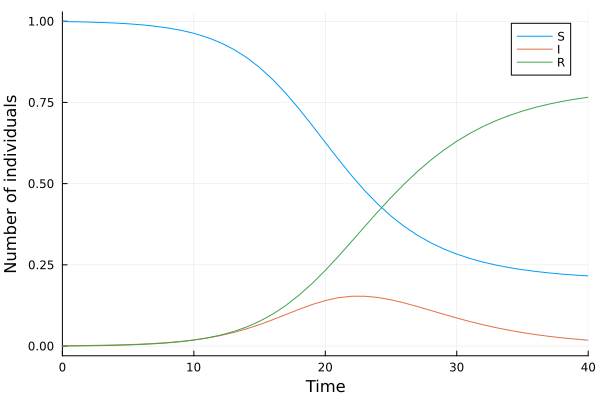

In [4]:
plot(sol, xlabel = "Time", ylabel = "Number of individuals", labels = ["S" "I" "R"])

### Add multiplicative log-normal noise

In [5]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.01)
noise = rand(rng, dist, size(X))
X_noisy = noise .* X;

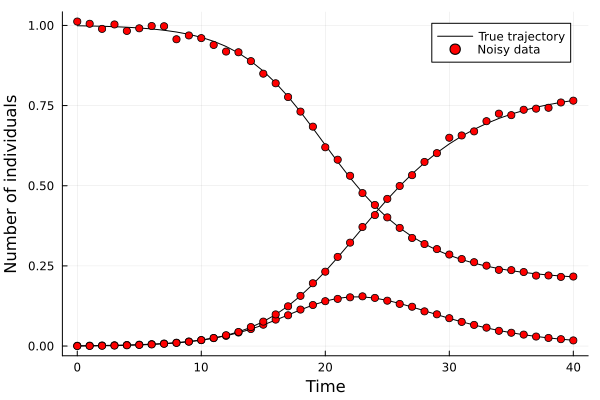

In [6]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals",
     color = :black, label=["True trajectory" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

### Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u)+\text{NN}(u)$.

In [7]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))   

# Multi-layer feed-forward neural network
model = Chain(Dense(3, 5, rbf), Dense(5, 5, rbf), Dense(5, 5, rbf), Dense(5, 3))

# Get initial parameters and state variables of the model
p_init, st = Lux.setup(rng, model);

In [8]:
# Define the hybrid model
β, γ, N = p_ODE

function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = -γ*u[2] + nn[2] 
    du[3] = γ*u[2] + nn[3]
end

prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### Set up the training

In [9]:
function predict(p)   # p is the parameter of the NN and the ODE at the same time
    _prob = remake(prob_ude, p=p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = t,
                sensealg=QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [10]:
function loss(p)
    X̂ = predict(p)
    mean(abs2, X_noisy .- X̂)   # MSE loss
end;

In [11]:
losses = Float64[]

function callback(p, l)
    push!(losses, l)
    n_iter = length(losses)
    if n_iter % 50 == 0   
        println("Loss after $(n_iter) iterations: $(losses[end])")
    end
    return false
end;

### Train the UDE

In [12]:
adtype = AutoZygote()   # automatic differentiation
optf = OptimizationFunction((p, _) -> loss(p), adtype)
optprob = OptimizationProblem(optf, ComponentVector{Float64}(p_init));

In [13]:
res1 = solve(optprob, ADAM(), callback = callback, maxiters = 5000);

Loss after 50 iterations: 1.818564524606704
Loss after 100 iterations: 0.9998842059923964
Loss after 150 iterations: 0.5996383157469011
Loss after 200 iterations: 0.3542130799156783
Loss after 250 iterations: 0.21764730572439295
Loss after 300 iterations: 0.14182610287354422
Loss after 350 iterations: 0.0975911779822014
Loss after 400 iterations: 0.07016788413700817
Loss after 450 iterations: 0.05222287512671537
Loss after 500 iterations: 0.03995743637586214
Loss after 550 iterations: 0.03128572426127433
Loss after 600 iterations: 0.024993804054220303
Loss after 650 iterations: 0.020336421022996133
Loss after 700 iterations: 0.016834395258297545
Loss after 750 iterations: 0.014167647133733412
Loss after 800 iterations: 0.01211572847439477
Loss after 850 iterations: 0.01052301141843371
Loss after 900 iterations: 0.009277377541161388
Loss after 950 iterations: 0.008296667380129378
Loss after 1000 iterations: 0.007519812296464193
Loss after 1050 iterations: 0.006900862867454511
Loss after

In [14]:
optprob2 = OptimizationProblem(optf, res1.u)
res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = 1500)
p_trained = res2.u;

Loss after 5050 iterations: 0.002390621883734631
Loss after 5100 iterations: 0.0017249368994395613
Loss after 5150 iterations: 0.0002910932934275128
Loss after 5200 iterations: 4.161913124624974e-5
Loss after 5250 iterations: 3.009919675133652e-5
Loss after 5300 iterations: 2.8149848324796302e-5
Loss after 5350 iterations: 2.6396929669162595e-5
Loss after 5400 iterations: 2.5904637255488607e-5
Loss after 5450 iterations: 2.5588434333520473e-5
Loss after 5500 iterations: 2.546524252334161e-5
Loss after 5550 iterations: 2.542173878175475e-5
Loss after 5600 iterations: 2.5335696281617053e-5
Loss after 5650 iterations: 2.5225126762374936e-5
Loss after 5700 iterations: 2.4506022836698307e-5
Loss after 5750 iterations: 2.3616134252296287e-5
Loss after 5800 iterations: 2.302210046937115e-5
Loss after 5850 iterations: 2.2424183943413026e-5
Loss after 5900 iterations: 2.2211976853026547e-5
Loss after 5950 iterations: 2.199563921039671e-5
Loss after 6000 iterations: 2.1653404215040655e-5
Loss af

### Visualize the results

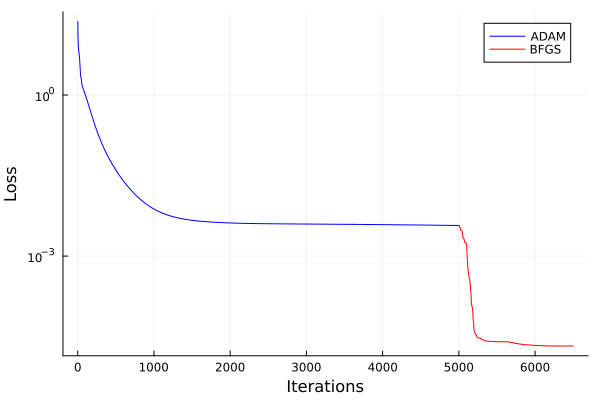

In [15]:
plot(1:5000, losses[1:5000], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM", color=:blue)
plot!(5001:length(losses), losses[5001:end], yaxis=:log10, label="BFGS", color = :red)

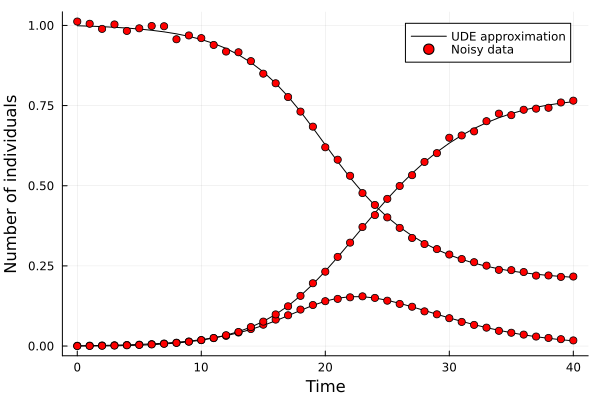

In [16]:
X̂ = predict(p_trained)
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

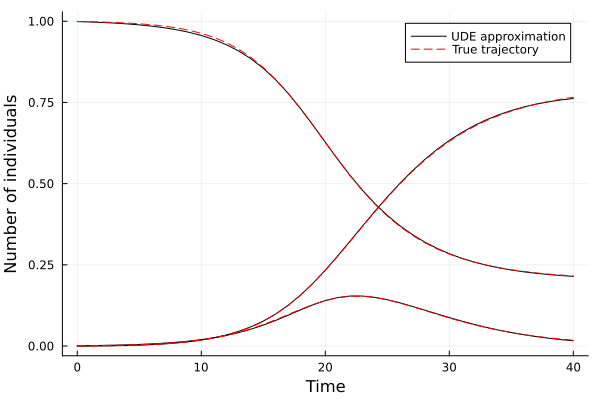

In [17]:
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
plot!(t, X', color = :red, linestyle=:dash, label=["True trajectory" nothing nothing])

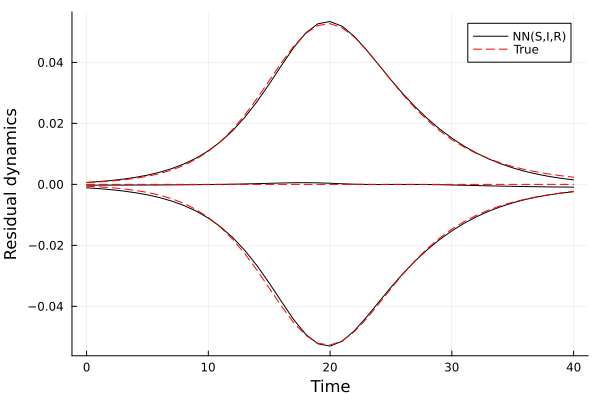

In [18]:
# True residual dynamics (i.e. interactions of predictors) along the true trajectory
dynamics_true = [-β/N * (X[1, :] .* X[2, :])'; β/N * (X[1, :] .* X[2, :])'; zeros(length(t))']
# Neural network guess along the approximated trajectory
dynamics_nn = Lux.apply(model, X̂, p_trained, st)[1]

plot(t, dynamics_nn', xlabel = "Time", ylabel = "Residual dynamics", color = :black,
     label = ["NN(S,I,R)" nothing nothing])
plot!(t, dynamics_true', color = :red, linestyle=:dash, label = ["True" nothing nothing])